In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy

In [2]:
# Function to compute velocity profile u/U as a function of y and t for fixed U and nu
def velocity_profile_rayleigh(y, nu, U, t):
    return U * (1 - erf(y / (2 * np.sqrt(nu * t))))
# Generate samples in the dataset
y_values        = np.linspace(0, 1, 20)                    # Distance from the plate (m)
t_values       = [1, 2, 5 ,10, 50]
#t_values = [ 8, 12, 16, 20]  # Different time values (s)
#t_values        = np.linspace(0.01, 5, 50)                 # Time values (s)
n_samples       = 10                                        # Number of samples for U and nu
U_samples       = np.random.uniform(0.5, 1.0, n_samples)   # Plate velocity (m/s)
nu_samples      = np.random.uniform(1e-3, 1e-2, n_samples) # Kinematic viscosity (m^2/s)

noise_mean = 0.0
noise_std = 0.01  # Adjust to control noise magnitude
u_list          = []
parameters_list = []

for i in range(n_samples):
    U_current   = U_samples[i]
    nu_current  = nu_samples[i]
    for y in y_values:
        for t in t_values:
            noise = np.random.normal(noise_mean, noise_std * U_current)
            u_value = velocity_profile_rayleigh(y, nu_current, U_current, t)
            u_list.append(u_value+noise)
            parameters_list.append([U_current, y, t, nu_current])
u_array          = np.array(u_list).reshape(-1, 1)  
parameters_array = np.array(parameters_list)


## Replace with your own input, dimensionless output, dimension matrix and variable name
Y                = u_array/parameters_array[:,0].reshape(-1,1)  #Output \Pi_o
X                = parameters_array                             #Dimensional input list q                         
variables_tauw   = ['U','y', 't','\\nu'];                       #Define variable name
D_in             = np.matrix('1 1 0 2;-1 0 1 -1')                           #Define D_in matrix 
num_input        = 1


In [3]:
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows          = np.shape(D_in)[0]
num_cols          = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows      = np.shape(D_in)[0]
    num_cols      = np.shape(D_in)[1]
    Din1, Din2    = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2       = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1       = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
# Generate basis matrices
num_basis        = D_in.shape[1] -matrix_rank(D_in)
basis_matrices   = calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 2
D_in matrix:
 [[ 1  1  0  2]
 [-1  0  1 -1]]
Basis vectors:
matrix([[-1.,  1., -1.,  0.],
        [ 1.,  1.,  0., -1.]])


In [4]:
def calc_pi(c, basis_matrices,X):
    coef_pi = np.dot(c, basis_matrices) 
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat
def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
        
    return pi_mat
def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape

    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1]

    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [5]:
def MI_input_output(para,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error') 
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    #MI = MI_d_binning(np.array(pi), np.array(Y), 50)
    MI = KraskovMI1_nats(np.array(pi), np.array(Y), 10)
    return -MI


In [6]:
num_para = num_basis*num_input
print('num of paraters:',num_para)
lower_bounds = [-2] * num_para  # exponent lower bound
upper_bounds = [2] * num_para   # exponent upper bound
bounds = [lower_bounds, upper_bounds]
options = {
    'bounds': bounds,
    'maxiter': 50000,  # maximum number of iterations
    'tolx': 1e-4,     # tolerance in solution variability
    'tolfun': 1e-4,   # tolerance in function value changes
    'popsize': 300,
}
es = CMAEvolutionStrategy([0.1] * num_para, 0.5,options)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [MI_input_output(x,basis_matrices,X,Y,num_basis,num_input) for x in solutions])
    es.disp()
es.result_pretty()
optimized_params = es.result.xbest
optimized_MI     = es.result.fbest
print('Optimized_params',optimized_params)
print('Optimized_MI',optimized_MI)

num of paraters: 2
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 2 (seed=678670, Wed Feb 26 13:13:26 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -2.219203276207985e+00 1.0e+00 7.83e-01  5e-01  7e-01 0:00.4
    2    600 -2.017251118610160e+00 1.9e+00 9.31e-01  4e-01  6e-01 0:00.8
    3    900 -2.123387311176936e+00 3.4e+00 1.06e+00  2e-01  3e-01 0:01.4
    9   2700 -2.231939794955087e+00 3.8e+01 2.95e+00  4e-02  4e-02 0:04.8
   17   5100 -2.234154243678084e+00 2.6e+01 7.06e+00  2e-03  2e-03 0:09.3
   27   8100 -2.234377972640640e+00 2.3e+01 1.57e+01  1e-04  1e-04 0:14.5
   28   8400 -2.234394349658999e+00 2.3e+01 1.60e+01  8e-05  9e-05 0:15.0
termination on tolx=0.0001
final/bestever f-value = -2.234394e+00 -2.234394e+00 after 8400/8320 evaluations
incumbent solution: [0.15785958871506928, 0.15750169469864353]
std deviation: [8.562734997994516e-05, 8.030430080417361e-05]
Optimized_params [0.15782577 0.15746442]
Optimized_MI -2.2343943

In [7]:
a_list                  = [tuple(optimized_params[i*num_basis:(i+1)*num_basis]) for i in range(num_input)]
# print('a_list:',a_list)
coef_pi_list            = [np.dot(a, basis_matrices) for a in a_list]
normalized_coef_pi_list = []
for coef_pi in coef_pi_list:
    max_abs_value       = np.max(np.abs(coef_pi))
    normalized_coef_pi  = coef_pi / max_abs_value
    normalized_coef_pi_list.append(np.round(normalized_coef_pi,1))
# Print the normalized coef_pi values
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    print(f'coef_pi{i+1}', normalized_coef_pi)

coef_pi1 [[-0.   1.  -0.5 -0.5]]


In [8]:
# Initialize labels
tauw_lab = []
qw_lab = []
omega_tauw = np.array(normalized_coef_pi_list)
omega_tauw = np.array(omega_tauw).reshape(-1, len(variables_tauw))
def create_labels(omega, variables):
    labels = []
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

tauw_lab = create_labels(omega_tauw, variables_tauw)
# Print the labels
for j, label in enumerate(tauw_lab):
    print(f'tauw_lab[{j}] = {label}')


tauw_lab[0] = $\frac{y^{1.0}}{t^{0.5} \cdot \nu^{0.5}}$


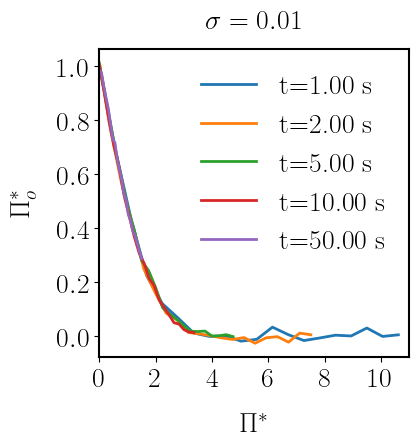

In [9]:
# Select the first U and nu from parameters_array
input_list = [calc_pi_omega(np.array(omega), X) for omega in normalized_coef_pi_list]
input_tauw = np.column_stack(input_list)
U_fixed = parameters_array[1, 0]  # First U value
nu_fixed = parameters_array[1, 3]  # First nu value

# Filter data for the fixed U and nu
indices_fixed = (parameters_array[:, 0] == U_fixed) & (parameters_array[:, 3] == nu_fixed)

plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True

# Extract Pi_i and Pi_o for all time values corresponding to the fixed U and nu
Pi_i = input_tauw[indices_fixed]
Pi_o = Y[indices_fixed]

# Extract unique times for labeling
unique_times = np.unique(parameters_array[indices_fixed, 2])

# Plot Pi_i vs. Pi_o
for i, t in enumerate(unique_times):
    # Get indices for the current time
    indices_time = parameters_array[indices_fixed, 2] == t
    
    # Plot for the current time
    plt.plot(Pi_i[indices_time], Pi_o[indices_time], lw=2, label=f't={t:.2f} s')

# Style and labels
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.xlabel(r' $\Pi^*$', fontsize=20, labelpad=15)
plt.ylabel(r" $\Pi_o^*$", fontsize=20, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0,11])
plt.legend(fontsize=20,frameon=False)
plt.title(rf' $\sigma = {noise_std:.2f}$', fontsize=20, pad=15)

plt.grid(False)

# Save the plot
filename_base = f'Noisy_velocity_profiles_fixed_U_nu_noise_std_{noise_std:.2f}'
plt.savefig(f'{filename_base}.png', dpi=400, bbox_inches='tight',transparent=True)
plt.savefig(f'{filename_base}.eps', dpi=400, bbox_inches='tight',transparent=True)
plt.show()
